# MSc Project : Understanding the data

### Using 2019 Monsoon season (JJAS) - Temp (at 2m) and Precipitaion (TRMM/GPM data) to find a relation b/w ERRs and maximum temperature for one site.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import netCDF4
# import pandas as pd
# from datetime import datetime
# from datetime import timedelta
# from scipy import stats
# import scipy.interpolate as interp
from dask.distributed import Client, Variable
%matplotlib inline

In [2]:
from functions import ccplot, binning

In [3]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
plt.style.use('seaborn-pastel')
sns.set_theme(style="ticks")

In [4]:
# Colormap selection
xr.set_options(cmap_divergent='BrBG', cmap_sequential='Blues')

## Data Preparation

In [5]:
# Getting the data

# client = Client()

mfdataDIR1 = './data/GPM_lowres_data/3B-HHR.MS.MRG.3IMERG.*.V06B.HDF5.nc'

ds1 = xr.open_mfdataset(mfdataDIR1, engine = 'netcdf4', combine = 'nested', concat_dim='time', parallel=True) # this is GPM IMERG data

In [6]:
mfdataDIR2 = './data/temp_data/data2.nc'
ds2 = xr.open_mfdataset(mfdataDIR2, parallel=True) # this is Temp data

In [7]:
# # convert the time array of T2 dataset
# ds2['time'] = xr.cftime_range(start = "2019-06-01 00:00:00", end = "2019-09-30 23:00:00", freq = "H")

In [8]:
# adding proper dates to ds1
# start = datetime(2019, 6, 1, 0, 0)
# end = datetime(2019, 9, 30, 23, 30)
# step = timedelta(minutes=30)

# dates = []

# while start < end:
#     dates.append(start.strftime('%Y-%m-%d %H:%M:%S'))
#     start += step

# ds1['time'] = dates

In [9]:
# # Import the TRMM data

# def add_time_dim(xda):
#     xda = xda.expand_dims(time = [datetime.now()])
#     return xda

# mfdataDIR3 = './data/TRMM_data/3B42.*.HDF.nc4'
# ds3 = xr.open_mfdataset(mfdataDIR3, parallel=True, preprocess=add_time_dim)

In [10]:
# # adding proper dates to ds3
# start = datetime(2019, 6, 1, 0)
# end = datetime(2019, 10, 1, 0)
# step = timedelta(hours=3)

# dates = []

# while start <= end:
#     dates.append(start.strftime('%Y-%m-%d %H:%M:%S'))
#     start += step

# ds3['time'] = dates

In [7]:
ds1 = ds1.drop_dims('bnds')

In [8]:
ds1 = ds1.transpose("time", "lat", "lon")
ds1

<xarray.Dataset>
Dimensions:                         (time: 5855, lon: 181, lat: 141)
Coordinates:
  * time                            (time) datetime64[ns] 2019-06-01 ... 2019...
  * lon                             (lon) float64 50.0 50.25 50.5 ... 94.75 95.0
  * lat                             (lat) float64 5.0 5.25 5.5 ... 39.75 40.0
Data variables:
    precipitationQualityIndex       (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    IRkalmanFilterWeight            (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    HQprecipSource                  (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    precipitationCal                (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    precipitationUncal              (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    HQprecipitation                 (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    HQobservationTime               (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    randomError                     (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    IRprecipitation                 (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
Attributes:
    CDI:                             Climate Data Interface version 1.9.10 (h...
    Conventions:                     CF-1.6
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/06;\nDOIauth...
    FileInfo:                        DataFormatVersion=6a;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         Tue Sep 14 08:54:14 2021: cdo -L -z zip_...
    CDO:                             Climate Data Operators version 1.9.10 (h...

In [9]:
ds2 = ds2.transpose("time", "latitude", "longitude")
ds2 = ds2.rename_dims({"latitude":"lat", "longitude":"lon"})
ds2 = ds2.rename_vars({"latitude":"lat", "longitude":"lon"})
ds2

<xarray.Dataset>
Dimensions:  (lon: 181, lat: 141, time: 2928)
Coordinates:
  * lon      (lon) float32 50.0 50.25 50.5 50.75 51.0 ... 94.25 94.5 94.75 95.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 6.0 5.75 5.5 5.25 5.0
  * time     (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
Data variables:
    u10      (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    v10      (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    d2m      (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-12 12:11:31 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [12]:
# ds3 = ds3.transpose('time', 'nlat', 'nlon')

In [13]:
# ds3 = ds3.sel(nlat=slice(5,40), nlon=slice(50,95))

In [14]:
# ds3

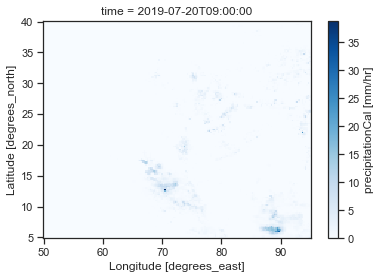

In [10]:
ds1.precipitationCal.sel(time = "2019-07-20 09:00:00").plot()

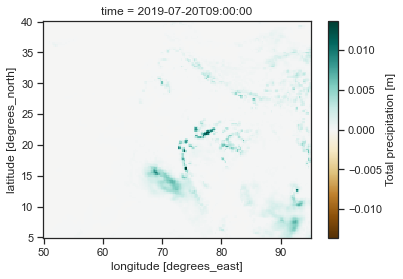

In [16]:
ds2.tp.sel(time = "2019-07-20 09:00:00").plot()

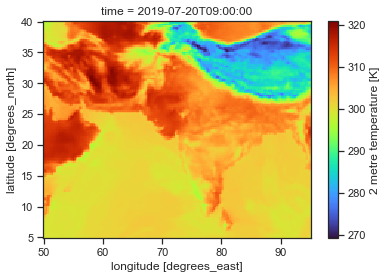

In [19]:
ds2.t2m.sel(time = "2019-07-20 09:00:00").plot(cmap='turbo')

In [18]:
# ds3.precipitation.sel(time = "2019-07-20 09:00:00").plot()

In [20]:
# precip30m = ds1.precipitationCal
precip1h = ds1.precipitationCal.resample(time = '1H').mean()
# precip3h = ds1.precipitationCal.resample(time = '3H').mean()
# precip6h = ds1.precipitationCal.resample(time = '6H').mean()
# precip12h = ds1.precipitationCal.resample(time = '12H').mean()
# precip1d = ds1.precipitationCal.resample(time = '1D').mean()

t2m = ds2.t2m
d2m = ds2.d2m
# u10 = ds2.u10
# v10 = ds2.v10
# tp = ds2.tp
# v = np.sqrt(u10**2 + v10**2)

In [21]:
# precip30m.shape

In [22]:
precip1h.shape

(2928, 141, 181)

In [23]:
t2m.shape

(2928, 141, 181)

In [24]:
d2m.shape

(2928, 141, 181)

In [25]:
ds_comb = xr.merge([precip1h, t2m, d2m]).chunk(dict(time=-1))

In [26]:
ds_comb

<xarray.Dataset>
Dimensions:           (lon: 181, lat: 141, time: 2928)
Coordinates:
  * lon               (lon) float64 50.0 50.25 50.5 50.75 ... 94.5 94.75 95.0
  * lat               (lat) float64 5.0 5.25 5.5 5.75 ... 39.25 39.5 39.75 40.0
  * time              (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
Data variables:
    precipitationCal  (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    t2m               (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    d2m               (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>

In [27]:
ds_comb.to_netcdf('./data/combined/ds_comb.nc')

/home/aditya/.miniconda/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Data binning

In [45]:
ds_comb = xr.open_dataset('./data/combined/ds_comb.nc')

In [46]:
ds_comb

<xarray.Dataset>
Dimensions:           (lon: 181, lat: 141, time: 2928)
Coordinates:
  * lon               (lon) float64 50.0 50.25 50.5 50.75 ... 94.5 94.75 95.0
  * lat               (lat) float64 5.0 5.25 5.5 5.75 ... 39.25 39.5 39.75 40.0
  * time              (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
Data variables:
    precipitationCal  (time, lat, lon) float32 ...
    t2m               (time, lat, lon) float32 ...
    d2m               (time, lat, lon) float32 ...

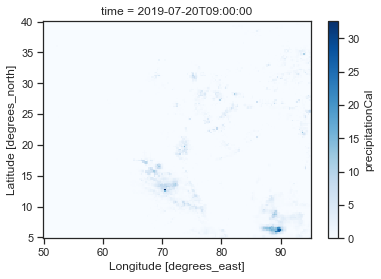

In [47]:
ds_comb.precipitationCal.sel(time = "2019-07-20 09:00:00").plot()

In [48]:
precip = ds_comb.precipitationCal
t2m = ds_comb.t2m
d2m = ds_comb.d2m

In [49]:
precip_daily_rate = precip[::-1].rolling(time=24).sum()[::-1]

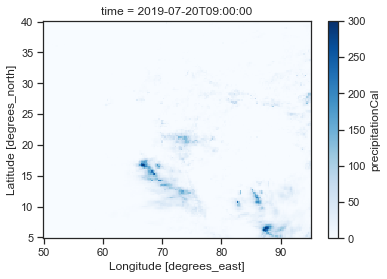

In [50]:
precip_daily_rate.sel(time = "2019-07-20 09:00:00").plot(vmin = 0, vmax = 300, extend = "neither")

In [51]:
# Set values less than 1 mm/hr to nan

precip = xr.where(precip_daily_rate < 1, np.nan, precip)
t2m = t2m.where(precip != np.nan)
d2m = d2m.where(precip != np.nan)

In [52]:
ds_comb = xr.merge([precip, t2m, d2m]).chunk(dict(time=-1))
ds_comb

<xarray.Dataset>
Dimensions:           (lon: 181, lat: 141, time: 2928)
Coordinates:
  * lon               (lon) float64 50.0 50.25 50.5 50.75 ... 94.5 94.75 95.0
  * lat               (lat) float64 5.0 5.25 5.5 5.75 ... 39.25 39.5 39.75 40.0
  * time              (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
Data variables:
    precipitationCal  (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    t2m               (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    d2m               (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>

In [53]:
mum = ds_comb.sel(lat = 19.5, lon = 72.5)

In [54]:
mum

<xarray.Dataset>
Dimensions:           (time: 2928)
Coordinates:
    lon               float64 72.5
    lat               float64 19.5
  * time              (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
Data variables:
    precipitationCal  (time) float32 dask.array<chunksize=(2928,), meta=np.ndarray>
    t2m               (time) float32 dask.array<chunksize=(2928,), meta=np.ndarray>
    d2m               (time) float32 dask.array<chunksize=(2928,), meta=np.ndarray>

In [55]:
binned_ds99 = binning.get_binned(mum, percentile_val=0.99, var = "t2m")

In [56]:
binned_ds50 = binning.get_binned(mum, percentile_val=0.50, var = "t2m")

In [57]:
temparr99, preciparr1_99, preciparr2_99 = ccplot.get_ideal_data(mum.t2m, 1, 6)
temparr50, preciparr1_50, preciparr2_50 = ccplot.get_ideal_data(mum.t2m, 0.005, 0.1)

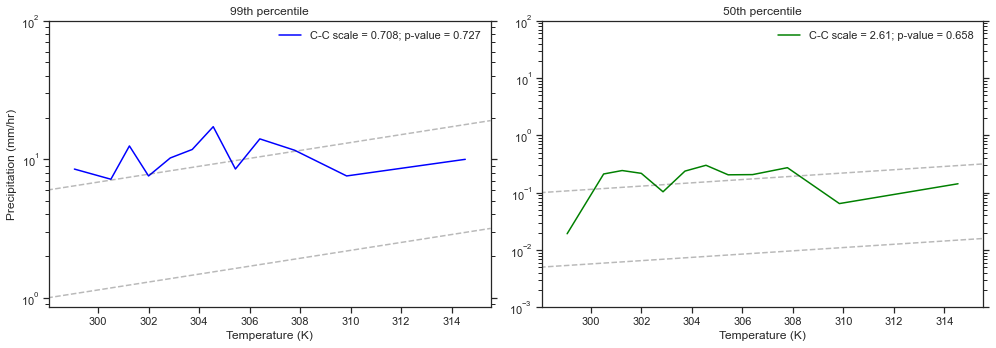

In [58]:
fig = plt.figure(figsize=(14,5))

plt.subplot(121)
ccplot.plot(mum.chunk(dict(time=-1)), binned_ds99, "t2m_bins", temparr99, preciparr1_99, preciparr2_99, fit=False, color = 'blue')
plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('99th percentile')

fig.gca().yaxis.set_ticks_position('both')

plt.subplot(122)
ccplot.plot(mum.chunk(dict(time=-1)), binned_ds50, "t2m_bins", temparr50, preciparr1_50, preciparr2_50, fit=False, color = 'green')

# plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('50th percentile')
plt.yticks([0.001, 0.01, 0.1, 1,10,100])

fig.gca().yaxis.set_ticks_position('both')
fig.tight_layout()
plt.savefig('./images/mumbai_ccplot.pdf', dpi = 300)

In [59]:
# fig = plt.figure(figsize=(14,5))

# plt.subplot(121)
# ccplot.plot(mum.chunk(dict(time=-1)), binned_ds99, "t2m_bins", temparr99, preciparr1_99, preciparr2_99, fit=True, marker = 'o', lw = 0., color = 'blue')
# plt.ylabel('Precipitation (mm/hr)')
# plt.xlabel('Temperature (K)')
# plt.title('99th percentile')

# fig.gca().yaxis.set_ticks_position('both')

# plt.subplot(122)
# ccplot.plot(mum.chunk(dict(time=-1)), binned_ds50, "t2m_bins", temparr50, preciparr1_50, preciparr2_50, fit=True, marker = '^', lw = 0., color = 'green')
# # plt.ylabel('Precipitation (mm/hr)')
# plt.xlabel('Temperature (K)')
# plt.title('50th percentile')
# plt.yticks([0.001, 0.01, 0.1, 1,10,100])

# fig.gca().yaxis.set_ticks_position('both')
# fig.tight_layout()
# plt.savefig('./images/mumbai_ccplot_fitted.pdf', dpi=300)

## Doing the same for dew point temperature

In [60]:
binned_ds99 = binning.get_binned(mum, percentile_val=0.99, var = "d2m")

In [61]:
binned_ds50 = binning.get_binned(mum, percentile_val=0.50, var = "d2m")

In [62]:
temparr99, preciparr1_99, preciparr2_99 = ccplot.get_ideal_data(mum.d2m, 1, 10)
temparr50, preciparr1_50, preciparr2_50 = ccplot.get_ideal_data(mum.d2m, 0.005, 0.1)

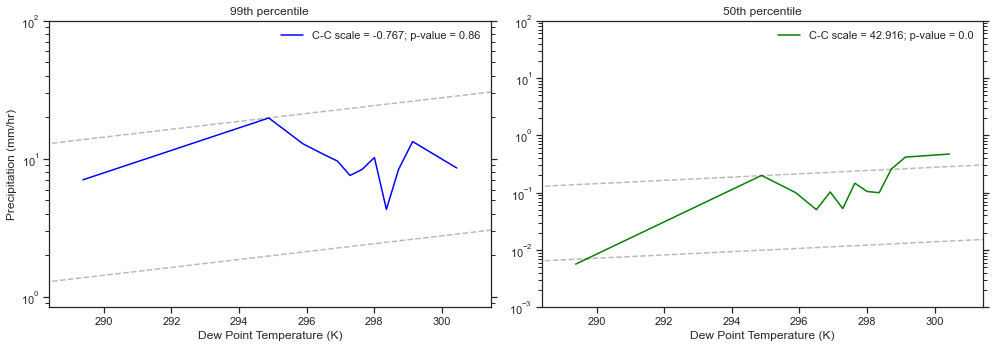

In [63]:
fig = plt.figure(figsize=(14,5))

plt.subplot(121)
ccplot.plot(mum.chunk(dict(time=-1)), binned_ds99, "d2m_bins", temparr99, preciparr1_99, preciparr2_99, fit=False, color = 'blue')
plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Dew Point Temperature (K)')
plt.title('99th percentile')

fig.gca().yaxis.set_ticks_position('both')

plt.subplot(122)
ccplot.plot(mum.chunk(dict(time=-1)), binned_ds50, "d2m_bins", temparr50, preciparr1_50, preciparr2_50, fit=False, color = 'green')
# plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Dew Point Temperature (K)')
plt.title('50th percentile')
plt.yticks([0.001, 0.01, 0.1, 1,10,100])


fig.gca().yaxis.set_ticks_position('both')
fig.tight_layout()
plt.savefig('./images/mumbai_ccplot_dew.pdf', dpi = 300)

In [25]:
# fig = plt.figure(figsize=(14,5))

# plt.subplot(121)
# ccplot.plot(mum.chunk(dict(time=-1)), binned_ds99, "d2m_bins", temparr, preciparr1, preciparr2, fit=True, marker = 'o', lw = 0., color = 'blue')
# plt.ylabel('Precipitation (mm/hr)')
# plt.xlabel('Dew Point Temperature (K)')
# plt.title('99th percentile')

# fig.gca().yaxis.set_ticks_position('both')

# plt.subplot(122)
# ccplot.plot(mum.chunk(dict(time=-1)), binned_ds50, "d2m_bins", temparr, preciparr1, preciparr2, color = 'green')
# # plt.ylabel('Precipitation (mm/hr)')
# plt.xlabel('Dew Point Temperature (K)')
# plt.title('50th percentile')

# fig.gca().yaxis.set_ticks_position('both')
# fig.tight_layout()
# plt.savefig('./images/mumbai_ccplot__dew_fitted.pdf', dpi=300)

## Quantile Regression

In [92]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

In [49]:
ds_comb = xr.open_dataset('./data/combined/ds_comb.nc')

In [50]:
ds_comb

<xarray.Dataset>
Dimensions:           (lon: 181, lat: 141, time: 2928)
Coordinates:
  * lon               (lon) float64 50.0 50.25 50.5 50.75 ... 94.5 94.75 95.0
  * lat               (lat) float64 5.0 5.25 5.5 5.75 ... 39.25 39.5 39.75 40.0
  * time              (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
Data variables:
    precipitationCal  (time, lat, lon) float32 ...
    t2m               (time, lat, lon) float32 ...
    d2m               (time, lat, lon) float32 ...

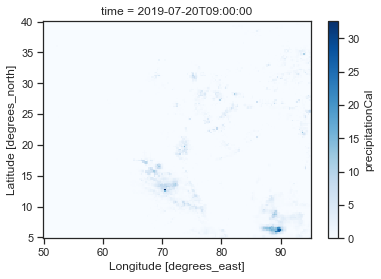

In [51]:
ds_comb.precipitationCal.sel(time = "2019-07-20 09:00:00").plot()

In [52]:
precip = ds_comb.precipitationCal
t2m = ds_comb.t2m
d2m = ds_comb.d2m

In [53]:
precip_daily_rate = precip[::-1].rolling(time=24).sum()[::-1]

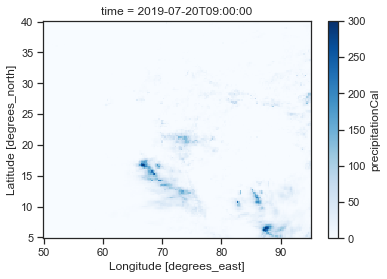

In [54]:
precip_daily_rate.sel(time = "2019-07-20 09:00:00").plot(vmin = 0, vmax = 300, extend = "neither")

In [55]:
# Set values less than 1 mm/hr to nan

precip = xr.where(precip < 1, np.nan, precip)
t2m = t2m.where(precip != np.nan)
d2m = d2m.where(precip != np.nan)

In [56]:
ds_comb = xr.merge([precip, t2m, d2m]).chunk(dict(time=-1))
ds_comb

<xarray.Dataset>
Dimensions:           (lon: 181, lat: 141, time: 2928)
Coordinates:
  * lon               (lon) float64 50.0 50.25 50.5 50.75 ... 94.5 94.75 95.0
  * lat               (lat) float64 5.0 5.25 5.5 5.75 ... 39.25 39.5 39.75 40.0
  * time              (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
Data variables:
    precipitationCal  (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    t2m               (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    d2m               (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>

In [57]:
mum = ds_comb.sel(lat = 19.5, lon = 72.5)

In [58]:
mum

<xarray.Dataset>
Dimensions:           (time: 2928)
Coordinates:
    lon               float64 72.5
    lat               float64 19.5
  * time              (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
Data variables:
    precipitationCal  (time) float32 dask.array<chunksize=(2928,), meta=np.ndarray>
    t2m               (time) float32 dask.array<chunksize=(2928,), meta=np.ndarray>
    d2m               (time) float32 dask.array<chunksize=(2928,), meta=np.ndarray>

In [107]:
df = mum.to_dataframe()
df.dropna(inplace=True)

In [108]:
df.head()

,lon,lat,precipitationCal,t2m,d2m
time,,,,,
2019-06-10 17:00:00,72.5,19.5,1.405377,308.648987,292.147308
2019-06-10 18:00:00,72.5,19.5,3.066377,308.678680,291.414520
2019-06-10 19:00:00,72.5,19.5,2.415174,309.008881,290.572205
2019-06-10 20:00:00,72.5,19.5,2.001226,307.688080,291.629822
2019-06-10 21:00:00,72.5,19.5,1.574566,307.326965,293.009766


In [109]:
model = smf.quantreg("np.log(precipitationCal) ~ t2m", df)

In [110]:
res = model.fit(q = 0.99)

In [111]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            QuantReg Regression Results                             
====================================================================================
Dep. Variable:     np.log(precipitationCal)   Pseudo R-squared:             0.004470
Model:                             QuantReg   Bandwidth:                      0.8305
Method:                       Least Squares   Sparsity:                        14.52
Date:                      Sat, 16 Oct 2021   No. Observations:                  430
Time:                              13:20:19   Df Residuals:                      428
                                              Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.7003      3.779     -1.773      0.077     -14.128       0.728
t2m            0.0312      0.012      2.528      0.012       0.007       0.055
==============================================================================

The condition number is large, 2.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [89]:
100*(np.exp(res.params.t2m) - 1)

3.1654162448922163

In [113]:
quantiles = np.arange(0.05, 0.96, 0.1)


def fit_model(q):
    res = model.fit(q=q)
    return [q, res.params.Intercept, 100*(np.exp(res.params.t2m) - 1), 100*(np.exp(res.conf_int().loc[
        "t2m"][0]) - 1), 100*(np.exp(res.conf_int().loc["t2m"][1]) - 1)]


models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])


print(models)

      q         a         b        lb        ub
0  0.05  1.414860 -0.437819 -1.885314  1.031031
1  0.15 -0.416282  0.210843 -1.691061  2.149542
2  0.25 -1.007019  0.462652 -1.675751  2.647561
3  0.35 -2.035380  0.862513 -1.663182  3.453079
4  0.45  0.802297 -0.006039 -2.922478  2.998017
5  0.55  0.023231  0.320437 -3.000144  3.754691
6  0.65 -0.196484  0.489619 -3.192794  4.312106
7  0.75  0.778864  0.249652 -3.273680  3.901323
8  0.85  8.343661 -2.087917 -5.720027  1.684118
9  0.95  3.782278 -0.469509 -4.346582  3.564711


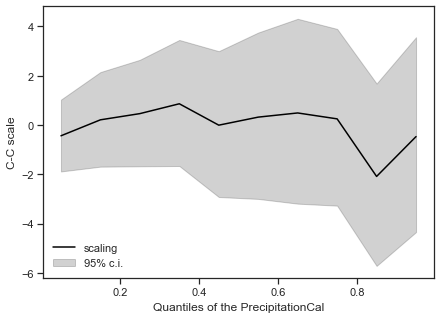

In [129]:
fig = plt.figure(figsize=(7,5))
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color="black", label="scaling")
p2 = plt.fill_between(models.q, models.lb, models.ub, color='k', alpha = 0.2, label = "95% c.i.")
plt.ylabel("C-C scale")
plt.xlabel("Quantiles of the PrecipitationCal")
plt.legend(frameon = False, loc="lower left")
plt.show()